# Feature Extraction in Electroluminescence Images of Photovoltaic Module Cells

> Created by: Samuel Madden

> Created on: February 06, 2020
> Last Updated : February 11, 2020

## 1. Introduction

*Keywords*:

Data Mining — Photovoltaic — Electroluminescence — Feature Extraction — Edge Detection — Solar Fault — Image Processing

*Abstract*:

There has been an exponential increase in the use of photovoltaic (PV) systems, most notably, the photovoltaic solar panel or solar cell. This naturally gives rise to the difficulties of operation and maintenance. With the combined use of unmanned aerial vehicles (UAV) and electroluminescence (EL) imaging, detailed aerial imagery of the PV systems may be collected and inspected for defects. The analysis of these images is a tedious and expensive manual process that can be alleviated by machine learning. An automated approach makes monitoring and upkeep of PV cells feasible.

*Goal*:

Using a collection of images that convey high spatial resolution, employ a suite of image processing and feature detection / description techniques to produce accurate and cost effective feature extraction.


#### 1.1 Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.elpv_reader import load_dataset

#### 1.2 Load Data

In [2]:
images, proba, types = load_dataset()

#### 1.3 File Structure & Content

In [3]:
types

array(['mono', 'mono', 'mono', ..., 'poly', 'poly', 'poly'], dtype='<U4')

In [4]:
images[0]

array([[14, 14, 14, ...,  9,  9,  9],
       [15, 15, 15, ..., 10,  9,  9],
       [15, 15, 16, ..., 10, 10, 10],
       ...,
       [29, 29, 29, ..., 19, 18,  4],
       [29, 29, 29, ..., 18, 18,  4],
       [29, 29, 29, ..., 18, 18,  4]], dtype=uint8)

In [5]:
images[0].shape

(300, 300)

In [6]:
proba_df = pd.DataFrame(data=proba, columns = ["P"])

In [7]:
proba_df.head(10)

,P
0,1.0
1,1.0
2,1.0
3,0.0
4,1.0
5,1.0
6,1.0
7,1.0
8,0.0
9,1.0


In [8]:
types_df = pd.DataFrame(data = types, columns = ["Types"])

#images_df = pd.DataFrame(data=images)

#### 1.4 Visualize Distribution

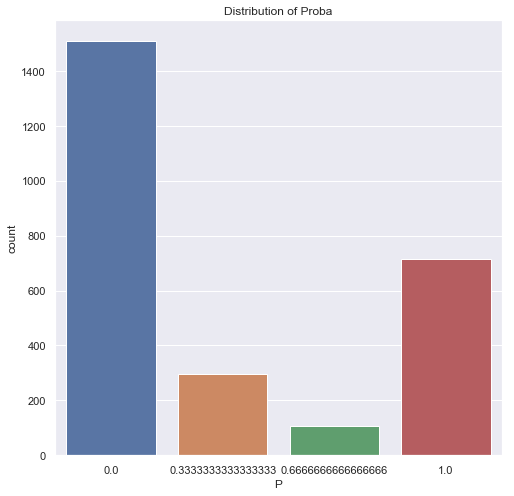

In [9]:
import seaborn as sns; sns.set()


plt.figure(figsize=(8, 8))
sns.countplot(x = "P", data = proba_df)
plt.title("Distribution of Proba")
plt.show()

In [10]:
types_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2624 entries, 0 to 2623
Data columns (total 1 columns):
Types    2624 non-null object
dtypes: object(1)
memory usage: 20.6+ KB


In [11]:
proba_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2624 entries, 0 to 2623
Data columns (total 1 columns):
P    2624 non-null float64
dtypes: float64(1)
memory usage: 20.6 KB


In [12]:
(proba_df.isnull()).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2624 entries, 0 to 2623
Data columns (total 1 columns):
P    2624 non-null bool
dtypes: bool(1)
memory usage: 2.6 KB


In [13]:
test_df = pd.concat([types_df["Types"], proba_df], axis = 1)

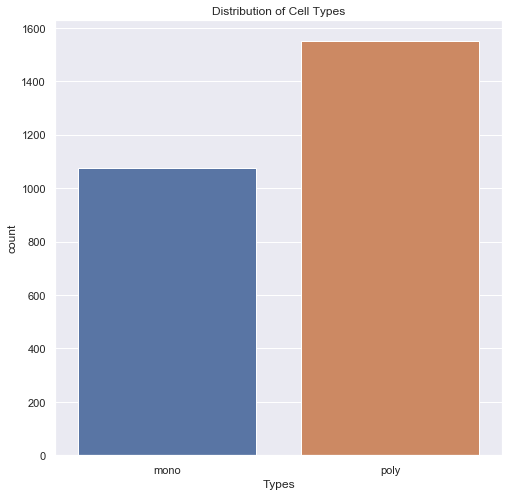

In [14]:
plt.figure(figsize=(8, 8))
sns.countplot(x = "Types", data = test_df)
plt.title("Distribution of Cell Types")
plt.show()

View relationship between proba and type

In [15]:
import random

# Add noise to data for better visualization

# noisyP_df = proba_df + (random(-standard_dev,standard_dev))
sigN = 0.1
noisyP_df = proba_df.copy()

for i in range(noisyP_df.shape[0]):
    a = random.uniform(-sigN,sigN)
    # add noise, round within 4 dec places)
    noisyP_df.at[i,'P'] = round(noisyP_df.at[i,'P']+ a, 6)
    if(noisyP_df.at[i,'P'] < 0): noisyP_df.at[i,'P'] = 0
    if(noisyP_df.at[i,'P'] > 1): noisyP_df.at[i,'P'] = 1


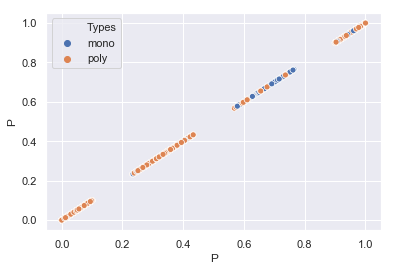

In [16]:
# push noisyP_df to a higher dim

x = noisyP_df['P']
y = noisyP_df['P']
classes = types_df['Types']

sns.scatterplot(x=x, y=y, hue=classes)
plt.show()

Detail of lower cluster, -0.01, 0.11

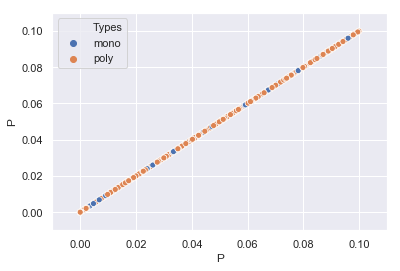

In [17]:
sns.scatterplot(x=x, y=y, hue=classes)

plt.ylim(-0.01, 0.11)
plt.xlim(-0.01, 0.11)

plt.show()

Detail of  lower mid cluster, 0.23, 0.435

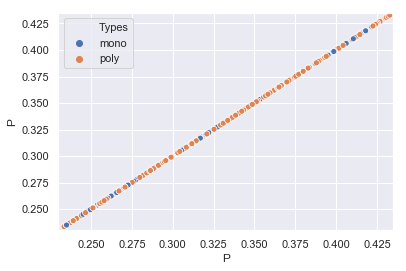

In [18]:
sns.scatterplot(x=x, y=y, hue=classes)

plt.ylim(0.23, 0.435)
plt.xlim(0.23, 0.435)

plt.show()

Detail of upper mid cluster, 0.56, 0.765

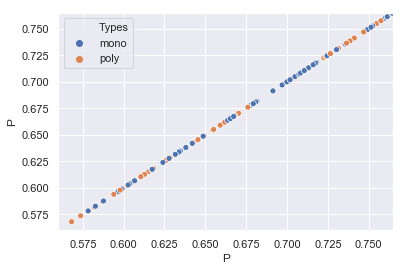

In [19]:
sns.scatterplot(x=x, y=y, hue=classes)

plt.ylim(0.56, 0.765)
plt.xlim(0.56, 0.765)

plt.show()

Detail of upper cluster, 0.895, 1.0

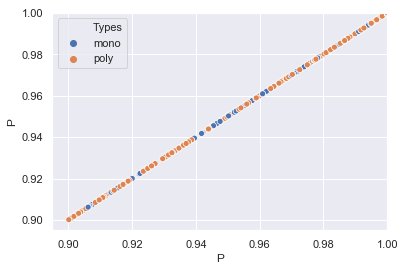

In [20]:
sns.scatterplot(x=x, y=y, hue=classes)

plt.ylim(0.895, 1.0)
plt.xlim(0.895, 1.0)

plt.show()

The majority of 'mono' solar cells exist in the region of 66% (likely to be damaged).

The other 3 clusters (Not Damaged - 0%, Likely Not Damaged - 33%, and Certainly Damaged - 100%) are dominated by the 'poly' solar cells

## 2. Computer Vision

The general approach to identifying the most potent feature vector is as follows: given a small set of images that represent the whole, apply an array of feature detection meth- ods to create a baseline for performance. Next apply masking techniques to highlight different attributes and reapply the feature detection methods. Compare and contrast against the baseline to conclude if a more accurate feature vector was achieved.

#### 2.1 Baseline Feature Extraction

All methods will be wrapped in functions for ease of use later in the notebook

Read in an image using OpenCV

In [21]:
import cv2

In [22]:
images[378]

array([[64, 64, 64, ..., 50, 50, 49],
       [64, 63, 64, ..., 51, 51, 50],
       [64, 64, 64, ..., 51, 51, 51],
       ...,
       [50, 50, 49, ..., 59, 58, 58],
       [49, 49, 49, ..., 59, 58, 58],
       [49, 49, 49, ..., 59, 58, 58]], dtype=uint8)

In [23]:
img = cv2.imread("images/cell0377.png") # default reads image as color image

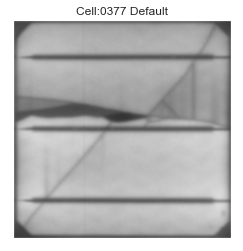

In [24]:
#cmap = 'gray', interpolation = 'bicubic'
plt.imshow(img, cmap= 'gray', interpolation = 'bicubic')
plt.title("Cell:0377 Default")
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

> #### 2.11 **(FAST)** Features from Accelerated Segment Test 

Now the pixel p is a corner if there exists a set of n contiguous pixels in the circle (of 16 pixels) which are all brighter than Ip+t, or all darker than Ip−t. (Shown as white dash lines in the above image). n was chosen to be 12.

In [25]:
# FAST ATTEMPT

# img = cv2.imread('images/cell0377.png')
# writepath = 'output_test/no_mask/fast_NMS.png'
# img is a cv2 read .png
# writepath: string - name and location of output


def fast(img, writepath):
    #img = cv2.imread('clahe_2.jpg',0)
    
    # Initiate FAST object with default values
    fastD = cv2.FastFeatureDetector_create()
    # find and draw the keypoints
    kp = fastD.detect(img,None)
    img2 = cv2.drawKeypoints(img, kp, None, color=(255,0,0))
    
    # Print all default params
    print( "Threshold: {}".format(fastD.getThreshold()) )
    print( "NonMaxSuppression:{}".format(fastD.getNonmaxSuppression()) )
    print( "neighborhood: {}".format(fastD.getType()) )
    print( "Total Keypoints with NonMaxSuppression: {}".format(len(kp)) )
    plt.imshow(img2),plt.title(writepath + " FAST"),plt.show()
    cv2.imwrite(writepath,img2)
    

The NonMax Suppression version of FAST is chosen as the default feature extraction method for the rest of this notebook. However the implementaion of FAST without NonMax Suppression may be found below.

In [26]:
# Create Keypoints without NonMax Suppression

# cell0377 is test image used in all examples
img = cv2.imread('images/cell0377.png',0) # 0 denotes being read in as grayscale
writepath = 'output_test/no_mask/fast_fNMS.png'

fastD = cv2.FastFeatureDetector_create()
# Disable nonmaxSuppression
fastD.setNonmaxSuppression(0)
kp = fastD.detect(img,None)
print( "Total Keypoints without nonmaxSuppression: {}".format(len(kp)) )
img3 = cv2.drawKeypoints(img, kp, None, color=(255,0,0))
cv2.imwrite(writepath,img3)

Total Keypoints without nonmaxSuppression: 209


True

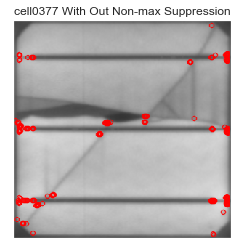

In [27]:
img_fast = cv2.imread("output_test/no_mask/fast_fNMS.png", 1)

plt.imshow(img_fast)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.title("cell0377 With Out Non-max Suppression")
plt.show()

Detection of corner pixels is fired several times

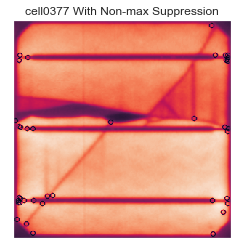

In [28]:
img_fast = cv2.imread('output_test/no_mask/fast_NMS.png', 0)

plt.imshow(img_fast)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.title("cell0377 With Non-max Suppression")
plt.show()

A more concentrated and clean list of corner pixels

> #### 2.12 **(SHI-TOMASI)** Corner Detection

In [29]:
img

array([[71, 71, 70, ..., 62, 61, 59],
       [71, 71, 70, ..., 61, 60, 59],
       [72, 71, 71, ..., 61, 60, 60],
       ...,
       [61, 61, 61, ..., 67, 66, 66],
       [61, 60, 60, ..., 67, 66, 65],
       [60, 60, 59, ..., 67, 66, 65]], dtype=uint8)

In [30]:
# SHI-TOMASI

#img = cv2.imread('images/cell0377.png')
#writepath = 'output_test/no_mask/shi-tom.png'

# img is a cv2 read .png
# writepath: string - name and location of output
def shiTom(img, writepath):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #gray = img
    corners = cv2.goodFeaturesToTrack(gray,25,0.01,10)
    corners = np.int0(corners)
    print( "Total Corners: {}".format(len(corners)) )
    for i in corners:
        x,y = i.ravel()
        cv2.circle(img,(x,y),3,255,-1)
    plt.imshow(img),plt.title(writepath + " shiTOM"),plt.show()
    cv2.imwrite(writepath,img)

> #### 2.12 **(ORB)** Oriented FAST and rotated BRIEF

In [31]:
# ORB ATTEMPT

#img = cv2.imread('images/cell0377.png',0)
#writepath = 'output_test/no_mask/orb.png'

# img is a cv2 read .png
# writepath: string - name and location of output

def orb(img, writepath):
    # Initiate ORB detector
    orb = cv2.ORB_create()
    # find the keypoints with ORB
    kp = orb.detect(img,None)
    # compute the descriptors with ORB
    kp, des = orb.compute(img, kp)
    print( "Total Keypoints: {}".format(len(kp)) )
    # draw only keypoints location,not size and orientation
    img2 = cv2.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)
    plt.imshow(img2), plt.title(writepath + " ORB"),plt.show()
    cv2.imwrite(writepath,img2)

> #### 2.14 HARRIS Corner Detection

In [32]:
# Harris Corner Detection

#img = cv2.imread('cell0377.jpg')
#writepath = 'output_test/no_mask/harris.png'

# img is a cv2 read .png
# writepath: string - name and location of output

def harris(img, writepath):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray,2,3,0.04)
    #result is dilated for marking the corners, not important
    dst = cv2.dilate(dst,None)
    print( "Total dst: {}".format(len(dst)) )
    # Threshold for an optimal value, it may vary depending on the image.
    img[dst>0.01*dst.max()]=[0,0,255]
    plt.imshow(img), plt.title(writepath + " HARRIS"),plt.show()
    cv2.imwrite(writepath, img)

> #### 2.15 Failed Attempts

In [33]:
# SIFT ATTEMPT
# ** PATENTED ** #

# opencv-python==3.4.2.16 or <

#img_gray = img

#sift = cv2.xfeatures2d.SIFT_create()
#kp = sift.detect(gray,None)

#img=cv2.drawKeypoints(gray,kp,img_gray)
#cv2.imwrite('cell0001_sift_keypoints.jpg',img_gray)

In [34]:
# SURF ATTTEMPT
# ** PATENTED ** #

# opencv-python==3.4.2.16 or <

#img_gray_0001 = cv2.imread("images/cell0001.png", 0) # 0 dictates channels read as grayscale
# Create SURF object.
# Set Hessian Threshold to 400
#surf = cv2.xfeatures2d.SURF_create(400)
# Find keypoints and descriptors directly
#kp, des = surf.detectAndCompute(img_gray_0001,None)
#len(kp)

### 2.2 Masking

(Text(0.5,1,'Sobel Y'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

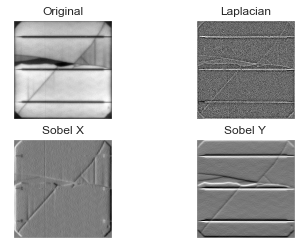

In [36]:
img = cv2.imread('images/cell0377.png',-1)

laplacian = cv2.Laplacian(img,cv2.CV_64F)
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)

plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

In [39]:
cv2.imwrite('output_test/sobely.png', sobely)
sy = cv2.imread('output_test/sobely.png')
cv2.imwrite('output_test/sobelx.png', sobelx)
sx = cv2.imread('output_test/sobelx.png',0)
#edges = cv2.Canny(sx,100,200)
#plt.imshow(edges),plt.title("test so canny")
#type(sobelx)

> #### 2.21 Histogram Equalization **(HE)**

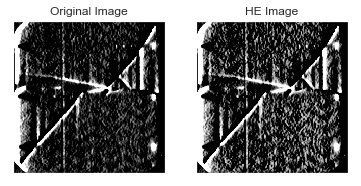

In [46]:
# Histograms Equalization
# Balancing contrast in B&W images

#imgN = cv2.imread('images/cell0377.png',0)
pathHE = 'output_test/hist_eq/'

def he(img, filename):
    # create a CLAHE object (Arguments are optional).
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(img)
    cv2.imwrite(pathHE + filename, cl1)
    

he(sx,'sobelx.png')
img_HE = cv2.imread(pathHE + 'sobelx.png', 1)
# print before and after
plt.subplot(121),plt.imshow(sx, cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_HE)
#, cmap = 'gray')
plt.title('HE Image'), plt.xticks([]), plt.yticks([])
plt.show()

(<matplotlib.image.AxesImage at 0x11edf0160>, Text(0.5,1,'test so canny'))

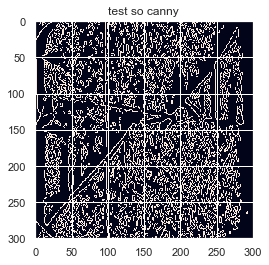

In [47]:
edges = cv2.Canny(img_HE,100,200)
plt.imshow(edges),plt.title("test so canny")

Threshold: 10
NonMaxSuppression:True
neighborhood: 2
Total Keypoints with NonMaxSuppression: 224


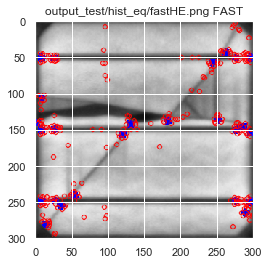

Total Keypoints: 186


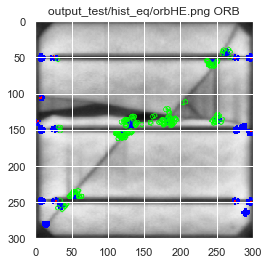

Total dst: 300


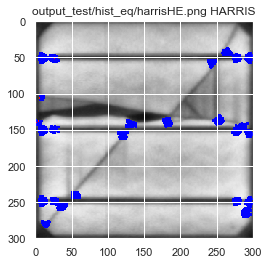

Total Corners: 25


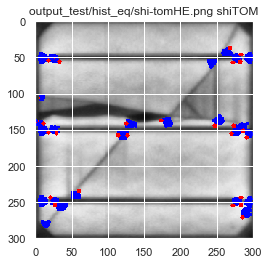

In [93]:
# run feature extraction on histogram equalized (HE) masked image

# FAST
fast(img_HE, pathHE + 'fastHE.png')
# Orb
orb(img_HE, pathHE + 'orbHE.png')
#Harris
harris(img_HE, pathHE + 'harrisHE.png')
# Shi-Tom 
shiTom(img_HE, pathHE + 'shi-tomHE.png')

> #### 2.22 Canny Edge Detection **(CED)**

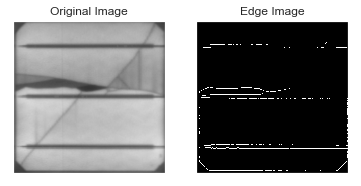

False

In [98]:
# CANNY EDGE DETECTION

pathCED = 'output_test/canny_edge/'

img = cv2.imread('images/cell0377.png',1)
edges = cv2.Canny(img,100,200)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()
cv2.imwrite(pathCED + 'baseCED.png', edges)

> #### 2.23 Hough Line Transformation **(HL)**

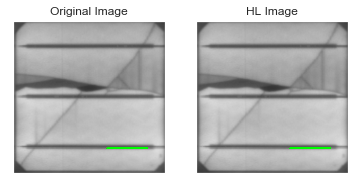

In [97]:
# Hough Line Transformation

pathHL = 'output_test/hough_line/'

img = cv2.imread('images/cell0377.png',1)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,50,150,apertureSize = 3)
minLineLength = 5
maxLineGap = 50
lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength,maxLineGap)
for x1,y1,x2,y2 in lines[0]:
    cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)
    
cv2.imwrite(pathHL + 'baseHL.png',img)
img_HL = cv2.imread(pathHL + 'baseHL.png')

# print before and after
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_HL,cmap = 'gray')
plt.title('HL Image'), plt.xticks([]), plt.yticks([])
plt.show()

> #### 2.24 Histogram of Oriented Gradients **(HOG)**

In [103]:
# Histogram of Oriented Gradients


# returns 4 vectors of 16 values, 64 values total
bin_n = 16

def hog(img):
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
    mag, ang = cv2.cartToPolar(gx, gy)
    bins = np.int32(bin_n*ang/(2*np.pi))    # quantizing binvalues in (0...16)
    bin_cells = bins[:10,:10], bins[10:,:10], bins[:10,10:], bins[10:,10:]
    mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
    hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
    hist = np.hstack(hists)     # hist is a 64 bit vector
    return hist


In [ ]:
# run feature extraction on Histogram of Oriented Gradients (HOG) masked image

# FAST
fast(img_HE, pathHE + 'fastHE.png')
# Shi-Tom 
shiTom(img_HE, pathHE + 'shi-tomHE.png')
# Orb
orb(img_HE, pathHE + 'orbHE.png')
#Harris
harris(img_HE, pathHE + 'harrisHE.png')